In [1]:
%load_ext autoreload
%autoreload 2

import xarray as xr
import os
from pathlib import Path
from lkf_tools.dataset import *
import dill
import warnings
warnings.filterwarnings('ignore')

In [41]:
lkf_data = process_dataset('./data/ice_2015_int.nc', output_path='./lkfs/',
                          dog_thres=0.05, t_red=1)

  -->  Compute dxu and dyu from lon,lat using SSMI projection


In [42]:
%%time
lkf_data.detect_lkfs(indexes=[0,1])

Compute deformation rates and detect features for day 1
Start detection routines
Compute deformation rates and detect features for day 2
Start detection routines
CPU times: user 4.03 s, sys: 32.8 ms, total: 4.06 s
Wall time: 3.75 s


In [43]:
dill.dump(lkf_data, file = open("lkf_pickle_files/lkf_data_2015_int_005.pickle", "wb"))

In [62]:
lkf_data_2015_nn_005 = dill.load(open("lkf_pickle_files/lkf_data_2015_nn_005.pickle", "rb"))
lkf_data_2015_int_005 = dill.load(open("lkf_pickle_files/lkf_data_2015_int_005.pickle", "rb"))

In [60]:
lkf_data = lkf_data_2015_nn_005

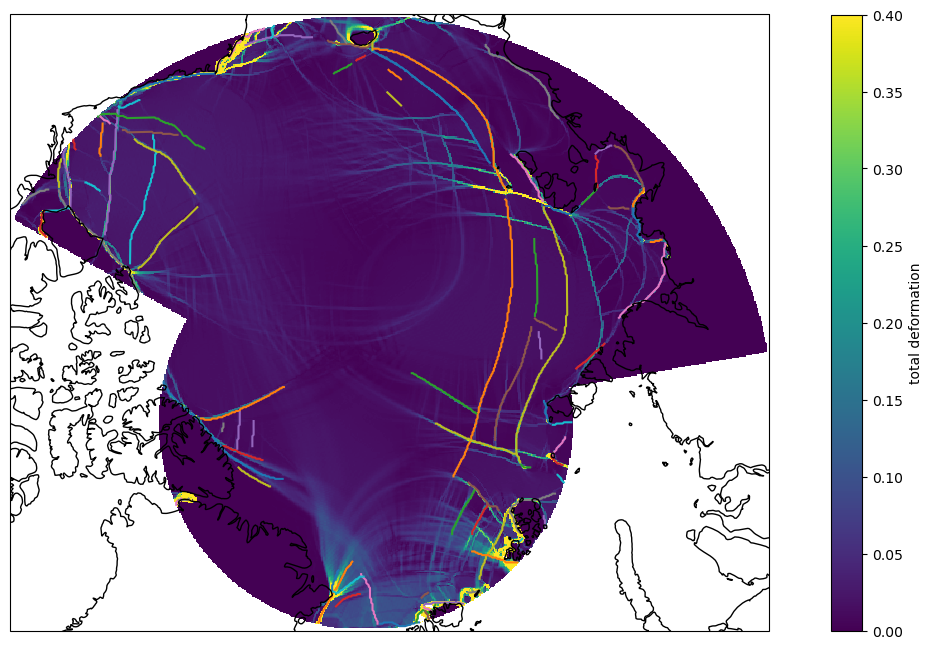

In [61]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig = plt.figure(figsize=[16, 8])

ax = plt.subplot(1, 1, 1, projection=ccrs.Orthographic(0, 90))

ax.coastlines(zorder=3)

pcm = ax.pcolormesh(lkf_data.lon[max([0,lkf_data.index_y[0][0]-1]):lkf_data.index_y[0][-1]+2:lkf_data.red_fac,
                       max([0,lkf_data.index_x[0][0]-1]):lkf_data.index_x[0][-1]+2:lkf_data.red_fac],
              lkf_data.lat[max([0,lkf_data.index_y[0][0]-1]):lkf_data.index_y[0][-1]+2:lkf_data.red_fac,
                       max([0,lkf_data.index_x[0][0]-1]):lkf_data.index_x[0][-1]+2:lkf_data.red_fac],
              np.sum(lkf_data.eps_tot_list,axis=0),transform=ccrs.PlateCarree(),vmin=0,vmax=0.4)

it = lkf_data.indexes[0]

lkfs = np.load(lkf_data.lkfpath.joinpath('lkf_%s_%03i.npy' %(lkf_data.netcdf_file.split('/')[-1].split('.')[0],(it+1))),allow_pickle=True)

for ilkf in lkfs:
    if np.min(ilkf[:,2])<-150 and np.max(ilkf[:,2]>150):
        ilkf[ilkf[:,2]<0,2]+=360
    ax.plot(ilkf[:,2],ilkf[:,3],transform=ccrs.PlateCarree())

plt.colorbar(pcm,label='total deformation')

### Track LKFs

After detecting LKFs, we can track LKFs using the drift fields to advect features. Since we only detected two time steps, we can just track the first pair, which we define with `indexes` again.

In [28]:
%%time
lkf_data.track_lkfs(indexes=[0])

Track features in lkf_ice_2015_nn_001.npy to lkf_ice_2015_nn_002.npy


After tracking the features, we will plot the tracked results to see if it worked appropriately.

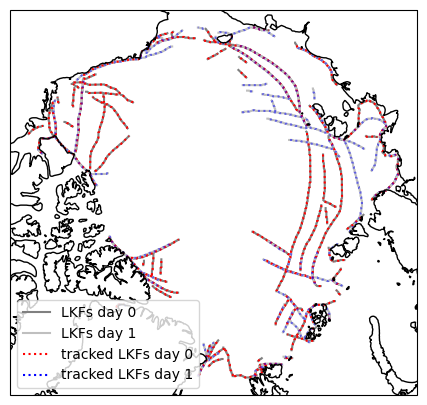

In [29]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig = plt.figure(figsize=[10, 5])

ax = plt.subplot(1, 1, 1, projection=ccrs.Orthographic(0, 90))

ax.coastlines(zorder=3)

it = 0

lkfs0 = np.load(lkf_data.lkfpath.joinpath('lkf_%s_%03i.npy' %(lkf_data.netcdf_file.split('/')[-1].split('.')[0],(it+1))),allow_pickle=True)
lkfs1 = np.load(lkf_data.lkfpath.joinpath('lkf_%s_%03i.npy' %(lkf_data.netcdf_file.split('/')[-1].split('.')[0],(it+2))),allow_pickle=True)

tracks = np.load(lkf_data.track_output_path.joinpath('lkf_tracked_pairs_%s_to_%s.npy' %(lkf_data.lkf_filelist[it][4:-4],
                                                                                        lkf_data.lkf_filelist[it+1][4:-4])),allow_pickle=True)

for ilkf in lkfs0:
    if np.min(ilkf[:,2])<-150 and np.max(ilkf[:,2]>150):
        ilkf[ilkf[:,2]<0,2]+=360
    ax.plot(ilkf[:,2],ilkf[:,3],'0.5',transform=ccrs.PlateCarree())
    
for ilkf in lkfs1:
    if np.min(ilkf[:,2])<-150 and np.max(ilkf[:,2]>150):
        ilkf[ilkf[:,2]<0,2]+=360
    ax.plot(ilkf[:,2],ilkf[:,3],'0.75',transform=ccrs.PlateCarree())

#for itrack in tracks:
#    ax.plot(lkfs0[itrack[0]][:,2],lkfs0[itrack[0]][:,3],'r:',alpha=0.25,transform=ccrs.PlateCarree())
#    ax.plot(lkfs1[itrack[1]][:,2],lkfs1[itrack[1]][:,3],'b:',alpha=0.25,transform=ccrs.PlateCarree())

for i in range(len(lkfs0)):
    ax.plot(lkfs0[i][:,2],lkfs0[i][:,3],'r:',alpha=1,transform=ccrs.PlateCarree())

for i in range(len(lkfs1)):
    ax.plot(lkfs1[i][:,2],lkfs1[i][:,3],'b:',alpha=0.5,transform=ccrs.PlateCarree())

    
ax.plot([0,0],[0,0],'0.5',label='LKFs day 0')
ax.plot([0,0],[0,0],'0.75',label='LKFs day 1')
ax.plot([0,0],[0,0],'r:',label='tracked LKFs day 0')
ax.plot([0,0],[0,0],'b:',label='tracked LKFs day 1')

ax.legend()